# Загружаем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import simfin as sf

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [84]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

In [3]:
#SimFin data

balance = pd.read_csv('data/balance.csv')
prices = pd.read_csv('data/prices.csv')

# Подготовка данных

Заполняем пропуски, убираем даты, для которых нет фундаментальных показателей

In [90]:
comp_balance = balance[balance['Ticker'] == 'MSFT'].drop(columns=['Ticker', 'SimFinId'])
comp_balance = comp_balance.rename(columns={'Report Date' : 'Date'})
comp_price = prices[prices['Ticker'] == 'MSFT'].drop(columns=['Ticker', 'SimFinId'])

data = pd.merge(comp_price, comp_balance, on='Date', how='outer')
data = data.dropna(subset=['Open'])
dividend = data['Dividend']

data = data.drop(columns=['Dividend'])
#
data = data.fillna(method='ffill')
data = data.drop(columns=['Treasury Stock'])

data = data.dropna()
#Логично дивиденды заполнить нулями, так как их не было
data['Dividend'] = dividend.fillna(0)
data = data.reset_index()
data = data.drop(columns=['index'])
data['Date'] = data['Date'].apply(lambda dt: datetime.datetime.strptime(dt, "%Y-%m-%d").strftime("%d.%m.%Y"))

In [91]:
data

,Date,Open,Low,High,Close,Adj. Close,Volume,Shares Outstanding,Currency,Fiscal Year,...,Short Term Debt,Total Current Liabilities,Long Term Debt,Total Noncurrent Liabilities,Total Liabilities,Share Capital & Additional Paid-In Capital,Retained Earnings,Total Equity,Total Liabilities & Equity,Dividend
0,30.06.2009,23.97,23.63,24.24,23.77,18.29,66452400.0,8.908000e+09,USD,2009.0,...,2.000000e+09,2.703400e+10,3.746000e+09,1.129600e+10,3.833000e+10,6.238200e+10,-2.282400e+10,3.955800e+10,7.788800e+10,0.0
1,01.07.2009,24.05,23.96,24.30,24.04,18.50,54908400.0,8.908000e+09,USD,2009.0,...,2.000000e+09,2.703400e+10,3.746000e+09,1.129600e+10,3.833000e+10,6.238200e+10,-2.282400e+10,3.955800e+10,7.788800e+10,0.0
2,02.07.2009,23.76,23.21,24.04,23.37,17.98,65422200.0,8.908000e+09,USD,2009.0,...,2.000000e+09,2.703400e+10,3.746000e+09,1.129600e+10,3.833000e+10,6.238200e+10,-2.282400e+10,3.955800e+10,7.788800e+10,0.0
3,06.07.2009,23.21,22.87,23.28,23.20,17.85,49207700.0,8.908000e+09,USD,2009.0,...,2.000000e+09,2.703400e+10,3.746000e+09,1.129600e+10,3.833000e+10,6.238200e+10,-2.282400e+10,3.955800e+10,7.788800e+10,0.0
4,07.07.2009,23.08,22.46,23.14,22.53,17.34,52842500.0,8.908000e+09,USD,2009.0,...,2.000000e+09,2.703400e+10,3.746000e+09,1.129600e+10,3.833000e+10,6.238200e+10,-2.282400e+10,3.955800e+10,7.788800e+10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2700,23.03.2020,137.01,132.52,140.57,135.98,134.61,78975176.0,7.606047e+09,USD,2020.0,...,6.247000e+09,5.964000e+10,6.336100e+10,1.130450e+11,1.726850e+11,7.962500e+10,3.048400e+10,1.101090e+11,2.827940e+11,0.0
2701,24.03.2020,143.75,141.27,149.60,148.34,146.85,82516727.0,7.606047e+09,USD,2020.0,...,6.247000e+09,5.964000e+10,6.336100e+10,1.130450e+11,1.726850e+11,7.962500e+10,3.048400e+10,1.101090e+11,2.827940e+11,0.0
2702,25.03.2020,148.91,144.44,154.33,146.92,145.44,75638224.0,7.606047e+09,USD,2020.0,...,6.247000e+09,5.964000e+10,6.336100e+10,1.130450e+11,1.726850e+11,7.962500e+10,3.048400e+10,1.101090e+11,2.827940e+11,0.0
2703,26.03.2020,148.40,148.37,156.66,156.11,154.54,64694427.0,7.606047e+09,USD,2020.0,...,6.247000e+09,5.964000e+10,6.336100e+10,1.130450e+11,1.726850e+11,7.962500e+10,3.048400e+10,1.101090e+11,2.827940e+11,0.0


# Порисуем графики

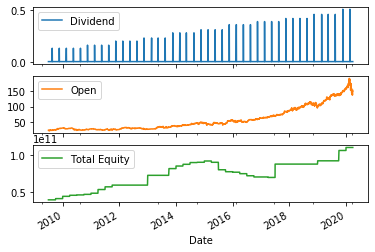

In [99]:
date_time = pd.to_datetime(data['Date'], format='%d.%m.%Y')

plot_cols = ['Dividend', 'Open', 'Total Equity']
plot_features = data[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

# Построение модели

In [95]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________
